# Simplicial approximation to CW complexes in practice: demo

Raphaël Tinarrage, https://raphaeltinarrage.github.io/ <br/>
September 2022

This page describes the implementation and use of the algorithm described in our paper *Simplicial approximation to CW complexes in practice* https://arxiv.org/abs/2112.07573

The code can be found at https://github.com/raphaeltinarrage/SimplicialApproximationCW

## Background 

The algorithm presented in this notebook has been designed to answer the following problem: given a CW complex, build a homotopy equivalent simplicial complex. It is an implementation of ideas already well-known in the literature.

Roughly speaking, a CW complex is a topological space obtained by iteratively gluing closed balls along their boundary. An example is given in the following figure: the sphere $\mathbb{S}^2$ can be obtained from a point, by gluing the two ends of an interval, so as to obtain a circle, and then gluing two disks on it, along their boundary. This gives a filtration of $\mathbb{S}^2$ by four sets, denoted $X_0 \subset X_1 \subset X_2 \subset X_3 = \mathbb{S}^2$. The set $X_i$ is called the $i^\mathrm{th}$ skeleton.

<img src="Fig1.png" width=800 height=700 />

In this context, the balls are called *cells*. If $\bar{\mathcal{B}}^d$ denotes a closed ball of dimension $d$, then its boundary is the $(d-1)$-sphere $\mathbb{S}^{d-1}$, and the gluing of $\bar{\mathcal{B}}^d$ on $X$ is specified by a map $\phi\colon \mathbb{S}^{d-1} \rightarrow X$, called a *gluing map*. The input of our algorithm will be the collection of the gluing maps.

Following the method described in our paper, we will build inductively simplicial complexes $K_0, \dots, K_3$, and for each of them a homotopy equivalence $h_i\colon X_i \rightarrow |K_i|$, where $|K_i|$ denote the geometric realization of $K_i$.
As it turns out, $K_{i}$ can be described as $\mathrm{Cone}^\mathrm{s}(\phi_{i}')$, the *simplicial mapping cone* of $\phi_{i}'$, where $\phi_{i}'$ is a simplicial map derived from the gluing map $\phi_{i}$.
The following figure represents this process.

<img src="Fig2.png" width=800 height=700 />

## Sketch of algorithm

We suppose that the input CW complex is given as a list **Cells = [Cells[0], Cells[1], $\dots$]**.
The data structure **Cells[i]** contains all the information relative to the $i^\mathrm{th}$ cell: 
- its dimension **Cells[i].Dimension**,
- its domain **Cells[i].Domain**,
- its gluing map **Cells[i].GluingMap**,
- its inverse characteristic map **Cells[i].InvCharacteristicMap**.

The algorithm builds a sequence of simplicial complexes **Skeleta[0]**, **Skeleta[1]**, ... as follows:
- We start with **Skeleta[0]**, a complex consisting of only one point.
- From **Skeleta[i-1]**, we glue the $i^\mathrm{th}$ cell as follows: 
    - we build a triangulation of the sphere, denoted **Sphere**,
    - we subdivise this sphere until the gluing map **Cells[i].GluingMap** satisfies the weak star condition,
    - we consider a weak simplicial approximation to the gluing map.
- We then build a triangulation of the ball, denoted **Ball**, and glue it to **Skeleta[i-1]**, via the weak simplicial approximation. This gives **Skeleta[i]**.

In order to perform the subdivision process, one method has to be choosen among:
- barycentric subdivisions,
- edgewise subdivisions,
- Delaunay barycentric subdivisions or
- Delaunay edgewise subdivisions.

Moreover, the algorithm contains two optional simplification steps: the **contraction of codomain**, which contract the skeleta via repeated edge contractions, and the **Delaunay simplification**, which reduce the spheres before gluing them. This latter step is only defined for Delaunay subdivisions.

## Implementation

The algorithm can be used as follows:

```python
method_subdivision = 'Delaunay-edgewise' #can also be 'barycentric', 'edgewise', 'Delaunay-barycentric' or 'Delaunay-center'
apply_contraction = True #True or False, whether to apply contractions
apply_simplification = True #True or False, whether to apply simplification (Delaunay only)
define_tree = False #True or False, whether to define trees (useless if apply_simplification is True)
method_gluing = 'star' #can also be 'homotopy' (required if apply_simplification is True)
verbose = True  #True or False, whether to print comments

for i in range(len(Cells)):
    Cell = Cells[i]

    if Cell.Dimension == 0:
        Skeleton = TriangulatePoint()
        Skeleton.add_Domain(Cells[i].Domain)

    else:
        Sphere = TriangulateSphere(dim=Cell.Dimension-1,subdivise=Cell.Subdivise,method=method_subdivision)
        LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap)
        SatisfyCondition, Vertices = CheckWeakStarCondition(Sphere.Complex, Skeleton.Complex, LocationMap)
        while not SatisfyCondition:
            Sphere = GeneralizedSubdivision(Sphere, Vertices, method_subdivision, define_tree)
            LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap, LocationMap)
            SatisfyCondition,Vertices = CheckWeakStarCondition(Sphere.Complex,Skeleton.Complex,LocationMap)
            InspectWeakStarCondition(Sphere, Vertices, Skeleton)
        if apply_simplification: 
            Sphere,Vertices = SimplifyDelaunay(Sphere.Complex,Skeleton.Complex,Vertices,Sphere.Coordinates)
        Ball = TriangulateBall(Sphere, verbose)
        Skeleton = GlueCell(Ball, Skeleton, Cell, Vertices, method_gluing)
        if apply_contraction: Skeleton = ContractTriangulation(Skeleton)
```

Let us describe each of these functions.
- **TriangulatePoint**: returns a triangulation of the topological space consisting of only one point.
- **TriangulateSphere**: returns a triangulation of the sphere $\mathbb{S}^d$ based on an embedding of $\partial \Delta^{d+1}$, the boundary of the standard $d$-simplex, in $\mathbb{R}^{d+1}$.
- **CheckWeakStarCondition**: checks whether the map **Cells[i].GluingMap**, from **Spheres.Complex** to **Skeleton.Complex**, satisfies the weak star condition. 
If it does not, **IsSimplicial** is **False**, and **Vertices** is the list of vertices where the map does not satisfy the weak star condition. If it does, **IsSimplicial** is **True**, and **Vertices** is a dictionary representing a weak simplicial approximation.
- **InspectWeakStarCondition**: gives certain information relative to the current triangulation (maximal edge length on which the weak star condition is not satisfied)
- **GeneralizedSubdivision**: performs a generalized subdivision to the simplicial complex **Sphere.Complex**.
- **TriangulateBall**: builds the simplicial cone on **Sphere**.
- **GlueCell**: builds the simplicial mapping cone of the simplicial map **Vertices** by identifying the outer part of **Ball** with **Skeleton**.

Moreover, the optional steps are:
- **ContractTriangulation**: contracts the triangulation **Skeleton** by repeated edge contractions.
- **SimplifyDelaunay**: simplifies the simplicial map **Vertices**, following the Delaunay simplification procedure.

A diagrammatic representation of the algorithm is given in the next figure. The variables on the arrows are the output of the functions in the boxes. Optional steps are represented in dashed.
<img src="Fig3.png" width=700 height=700 />

## Organization of the notebook
    
We shall apply the algorithm on the following spaces:    
- the real projective space $\mathbb{R}P^3$,
- the lens spaces $L(p,q)$,
- the Grassmannian $\mathcal{G}(2,4)$,
- the complex projective spaces $\mathbb{C}P^2$,
- the special orthogonal group $SO(3)$.

## Theoretical guarantees

Let us raise two important point concerning the algorithm (see Subsection 4.2 of the paper):
- **Termination:** in general, the algorithm may not terminate. In order to ensure that it does, one can use global subdivisions instead of generalized subdivisions. However, the algorithm did terminate on the examples of this notebook.
- **Correctness:** even if the algorithm terminates, the output simplicial complex may not be homotopy equivalent to the initial CW complex. In order to verify this homotopy equivalence, further verification steps must be used, which we did not implement. In this notebook, we only verified that the simplicial complexes had the correct homology groups over $\mathbb{Z}/2\mathbb{Z}$ and $\mathbb{Z}/3\mathbb{Z}$. As a further sanity check, one can compute their homology over $\mathbb{Z}$ and their fundamental groups, using for instance the package *simpcomp* of *GAP*, as follows:

```C++
LoadPackage("simpcomp");
file:="./Complexes/RP3_1_GAP.txt";;
Read(file);; c:=SCFromFacets(simplices);
SCHomology(c); 
g:=SCFundamentalGroup(c);; StructureDescription(g);  
```

## Functions

In [1]:
from functions import *
                
def main(verbose=True):            
    for i in range(len(Cells)):
        Cell = Cells[i]

        if Cell.Dimension == 0:
            Skeleton = TriangulatePoint()
            Skeleton.add_Domain(Cells[i].Domain)

        else:
            Sphere = TriangulateSphere(dim=Cell.Dimension-1,subdivise=Cell.Subdivise,method=method_subdivision)
            LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap)
            SatisfyCondition, Vertices = CheckWeakStarCondition(Sphere.Complex, Skeleton.Complex, LocationMap,verbose=Cell.Dimension>2 and verbose)
            while not SatisfyCondition:
                InspectWeakStarCondition(Sphere, Vertices, Cell, Skeleton, verbose=Cell.Dimension>3 and verbose)
                Sphere = GeneralizedSubdivision(Sphere, Vertices, method=method_subdivision, verbose=Cell.Dimension>3 and verbose)
                LocationMap = GetGluingLocationMap(Sphere, Skeleton, Cell.GluingMap, LocationMap, verbose=Cell.Dimension>3 and verbose)
                SatisfyCondition,Vertices = CheckWeakStarCondition(Sphere.Complex,Skeleton.Complex,LocationMap, verbose=Cell.Dimension>2 and verbose)
            if apply_simplification: 
                Sphere, Vertices = SimplifyDelaunay(Sphere.Complex, Skeleton.Complex, Vertices,  Sphere.Coordinates, verbose=Cell.Dimension>2 and verbose)
            Ball = TriangulateBall(Sphere)
            Skeleton = GlueCell(Ball, Skeleton, Cell, Vertices, method_gluing)
            if apply_contraction: Skeleton = ContractTriangulation(Skeleton, verbose=verbose)
                
        if verbose:
            print('Cell of dim '+repr(Cell.Dimension)+' glued, the complex has '+repr(Skeleton.Complex.num_vertices())+' vertices.')
            PrintHomology(Skeleton)
            print()
        
    return Skeleton

# Experiment I: the real projective space $\mathbb{R}P^3$

The space $\mathbb{R}P^3$ is a 3-dimensional manifold, with integral homology groups $\mathbb{Z}$, $\mathbb{Z}/2\mathbb{Z}$, $0$ and $\mathbb{Z}$, and fundamental group $\mathbb{Z}/2\mathbb{Z}$.

We shall compare the performance of the algorithm using the four subdivisions methods (*barycentric*, *edgewise*, *Delaunay-barycentric* and *Delaunay-edgewise*), as well as the two speed-ups (*edge contractions* and *Delaunay simplifications*).

## I-1: With edge contractions

We first build the list **Cells**, that represent the data of the gluing maps of the projective spaces.
In order to ensure the termination of the algorithm, we have to perform an initial number of subdivisions on each cell. This number is prescribed by the value **Cell.Subdivise**.

In [2]:
Cells = []
Subdivise = {0:0, 1:0, 2:2, 3:2}
for i in range(len(Subdivise)):
    Cell = ClassCell()
    Cell.Dimension = i
    Cell.Subdivise = Subdivise[i]
    Cell.add_Domain(DomainProjectiveSpace)
    Cell.add_GluingMap(GluingMapProjectiveSpace)
    Cell.add_InvCharacteristicMap(InvCharacteristicMapProjectiveSpace)
    Cells.append(Cell)  

We now apply the algorithm **main()**, with barycentric subdivisions first. 
By applying edge contractions, we reduce the size of the simplicial complexes at each step.

In [3]:
# barycentric subdivision, with contractions
# /!\ long computation time

method_subdivision = 'barycentric'
apply_contraction = True
apply_simplification = False
method_gluing = 'star'

RP3_1 = main()
SaveSimplexTree(RP3_1.Complex, 'RP3_1'); SaveSimplexTreeGAP(RP3_1.Complex, 'RP3_1');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 25/32. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/37/7.
Cell of dim 2 glued, the complex has 7 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| CheckWeakStarCondition | weak star condition not satisfied for 51.351% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 24.405% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 11.814% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 7.676% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 2

The output is a simplicial complex with 739 vertices, potentially homotopy equivalent to $\mathbb{R}P^3$. 

We now apply the algorithm with the *edgewise subdivision* method.

In [4]:
# edgewise subdivision, with contractions

method_subdivision = 'edgewise'
apply_contraction = True
apply_simplification = False
method_gluing = 'star'

RP3_2 = main()
SaveSimplexTree(RP3_2.Complex, 'RP3_2'); SaveSimplexTreeGAP(RP3_2.Complex, 'RP3_2');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 25/32. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/37/7.
Cell of dim 2 glued, the complex has 7 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| CheckWeakStarCondition | weak star condition not satisfied for 73.529% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 54.545% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 22.129% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 10.669% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 

The resulting complex has 46 vertices, way less than with barycentric subdivisions.

As described in our paper, another subdivision method is based on the notion *Delaunay triangulations*. In the two next cells, we experiment the algorithm for *Delaunay barycentric* and *Delaunay edgewise* subdivisions. Again, the simplicial complexes contain respectively less vertices than previously: 185 and 29.

In [5]:
# Delaunay-barycentric subdivision, without contractions

method_subdivision = 'Delaunay-barycentric'
apply_contraction = True
apply_simplification = False
method_gluing = 'star'

RP3_3 = main()
SaveSimplexTree(RP3_3.Complex, 'RP3_3'); SaveSimplexTreeGAP(RP3_3.Complex, 'RP3_3');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 25/32. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/37/7.
Cell of dim 2 glued, the complex has 7 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| CheckWeakStarCondition | weak star condition not satisfied for 62.162% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 19.318% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 6.513% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 1.899% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 0.

In [6]:
# Delaunay-edgewise subdivision, without contractions

method_subdivision = 'Delaunay-edgewise'
apply_contraction = True
apply_simplification = False
method_gluing = 'star'

RP3_4 = main()
SaveSimplexTree(RP3_4.Complex, 'RP3_4'); SaveSimplexTreeGAP(RP3_4.Complex, 'RP3_4');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 25/32. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/37/7.
Cell of dim 2 glued, the complex has 7 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| CheckWeakStarCondition | weak star condition not satisfied for 79.412% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 49.194% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 18.927% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 8.846% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 3

## I-2: With Delaunay simplifications

Using Delaunay complexes, we can use another simplification step. This allows significantly faster computations.  When using these *Delaunay simplifications*, it is preferable to use the *homotopy gluing* method.

We first experiment with the Delaunay-barycentric subdivisions. The resulting complex has 19 vertices, less than the 185 vertices obtained aboved, without simplifications.

In [7]:
# Delaunay-barycentric subdivision, with contractions and simplification

method_subdivision = 'Delaunay-barycentric'
apply_contraction = True
apply_simplification = True
method_gluing = 'homotopy'

RP3_5 = main();
SaveSimplexTree(RP3_5.Complex, 'RP3_5'); SaveSimplexTreeGAP(RP3_5.Complex, 'RP3_5');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 5/11. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/31/6.
Cell of dim 2 glued, the complex has 6 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| CheckWeakStarCondition | weak star condition not satisfied for 56.757% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 11.932% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 3.523% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 1.815% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 0.1

We now reproduce the same experiment with Delaunay-edgewise subdivisions.
We obtain a last complex with 18 vertices.

In [8]:
# Delaunay-edgewise subdivision, with contractions and simplification

method_subdivision = 'Delaunay-edgewise'
apply_contraction = True
apply_simplification = True
method_gluing = 'homotopy'

RP3_6 = main();
SaveSimplexTree(RP3_6.Complex, 'RP3_6'); SaveSimplexTreeGAP(RP3_6.Complex, 'RP3_6');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 5/11. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/31/6.
Cell of dim 2 glued, the complex has 6 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| CheckWeakStarCondition | weak star condition not satisfied for 76.471% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 41.463% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 10.746% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 4.715% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 1.

We point out that the output of this algorithm is not deterministic. Indeed, some random choices are made while choosing a weak simplicial approximation, while performing the Delaunay simplification and during edge contractions. In some cases, one obtains a last simplicial complex with only $11$ vertices, which is the minimal number of vertices of a triangulation of $\mathbb{R}P^3$

The following figure represents the last cell computed by the algorithm. It is a triangulation of the sphere. One observes that the cell has been preferentially subdivided near the poles.

/home/rtina/python-environments/tda-env/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/rtina/python-environments/tda-env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


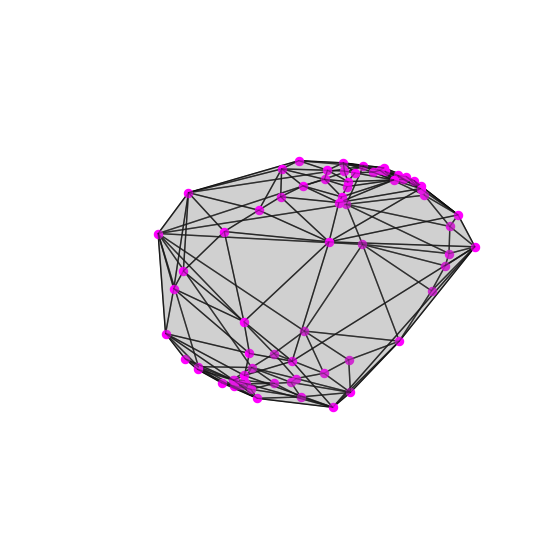

In [10]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
figsize = (10,10)

# Ball dim 3
tr = RP3_6.Parent.NewTriangulation.Boundary
Edges = (filtr[0] for filtr in tr.Complex.get_filtration() if len(filtr[0])==2)
fig = plt.figure(figsize = figsize); ax = fig.add_subplot(111, projection='3d')
X = np.array(list(tr.Coordinates.values())) 
for edge in Edges:
    ax.plot([X[edge[0]][0], X[edge[1]][0]], [X[edge[0]][1], X[edge[1]][1]], [X[edge[0]][2], X[edge[1]][2]], color='black', alpha=.9)
Triangles = (filtr[0] for filtr in tr.Complex.get_filtration() if len(filtr[0])==3)
Patches = []
for triangle in Triangles:
    verts = [tr.Coordinates[v] for v in triangle]
    ax.add_collection3d(Poly3DCollection(verts, alpha=0.2, color='grey', edgecolor='black',linewidths=1.25)) 
for i in tr.Coordinates.keys():
    ax.scatter3D(X[i, 0], X[i, 1], X[i, 2], color = 'magenta', lw = 5, alpha = 1)    
velour.set_axes_equal(ax); plt.axis('off'); plt.axis('tight');

# Experiment II: the lens spaces $L(p,q)$

The 3-dimensional lens spaces $L(p,q)$ are parametrized by $p$ and $q$, two coprime integers.
Its integral homology groups are $\mathbb{Z}$, $\mathbb{Z}/p\mathbb{Z}$, $0$ and $\mathbb{Z}$, and its fundamental group is $\mathbb{Z}/p\mathbb{Z}$.

We shall apply the algorithm for all coprimes $(p,q)$ with $p \in [2, 6]$ and $q \in [1,3]$.

In [13]:
import math
from collections import OrderedDict

method_subdivision = 'Delaunay-edgewise'
apply_contraction = True
apply_simplification = True
method_gluing = 'homotopy'

Pairs = [tuple([p,q]) for p in range(2,6+1) for q in range(1,3+1) if math.gcd(p,q)==1]
TriangulationsLensSpaces = OrderedDict()
for [p,q] in Pairs:
    Cells = [ClassCell() for i in range(4)]
    for i in range(4): Cells[i].p, Cells[i].q = p, q
    Cells[0].Dimension, Cells[1].Dimension, Cells[2].Dimension, Cells[3].Dimension = 0, 1, 2, 3
    Cells[0].Subdivise, Cells[1].Subdivise, Cells[2].Subdivise, Cells[3].Subdivise = 0, 0, p, 2
    Cells[1].add_Domain(DomainLensSpace1); Cells[1].add_GluingMap(GluingMapLensSpace1); Cells[1].add_InvCharacteristicMap(InvCharacteristicMapLensSpace1)
    Cells[2].add_Domain(DomainLensSpace2); Cells[2].add_GluingMap(GluingMapLensSpace2); Cells[2].add_InvCharacteristicMap(InvCharacteristicMapLensSpace2)
    Cells[3].add_Domain(DomainLensSpace3); Cells[3].add_GluingMap(GluingMapLensSpace3); Cells[3].add_InvCharacteristicMap(InvCharacteristicMapLensSpace3)

    Lpq = main(verbose=False);
    print('L('+repr(p)+','+repr(q)+') has '+repr(Lpq.Complex.num_vertices())+' vertices.')
    PrintHomology(Lpq, Primes=[2,3,5])
    TriangulationsLensSpaces[tuple([p,q])] = Lpq
    SaveSimplexTreeGAP(Lpq.Complex, 'L'+repr(p)+repr(q))
    print()

L(2,1) has 12 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1  -  H3 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1
Homology over p=5:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1

L(2,3) has 12 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1  -  H3 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1
Homology over p=5:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1

L(3,1) has 15 vertices.
Homology over p=2:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1
Homology over p=3:   H0 = 1  -  H1 = 1  -  H2 = 1  -  H3 = 1
Homology over p=5:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1

L(3,2) has 24 vertices.
Homology over p=2:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1
Homology over p=3:   H0 = 1  -  H1 = 1  -  H2 = 1  -  H3 = 1
Homology over p=5:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1

L(4,1) has 29 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1  -  H3 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0  -  H3 = 1
Homology over p=5:   H

We observe that the simplicial complexes have the same homology groups than $L(p,q)$ over $\mathbb{Z}/2\mathbb{Z}$, $\mathbb{Z}/3\mathbb{Z}$ and $\mathbb{Z}/5\mathbb{Z}$.

# Experiment III: the Grassmannian $\mathcal{G}(2,4)$

The Grassmannian $\mathcal{G}(2,4)$ can be seen as the set of $2$-planes in $\mathbb{R}^4$. It is a manifold of dimension $4$. Its integral homology groups are $\mathbb{Z}$, $\mathbb{Z}/2\mathbb{Z}$, $\mathbb{Z}/2\mathbb{Z}$, $0$ and $\mathbb{Z}$, and its fundamental group is $\mathbb{Z}/2\mathbb{Z}$. In particular, 
- its homology with $\mathbb{Z}/2\mathbb{Z}$ coefficients is $\mathbb{Z}/2\mathbb{Z}$, $\mathbb{Z}/2\mathbb{Z}$, $(\mathbb{Z}/2\mathbb{Z})^2$, $\mathbb{Z}/2\mathbb{Z}$ and $\mathbb{Z}/2\mathbb{Z}$, 
- for $p>2$, its homology with $\mathbb{Z}/p\mathbb{Z}$ coefficients is $\mathbb{Z}/p\mathbb{Z}$, $0$, $0$, $0$, and $\mathbb{Z}/p\mathbb{Z}$.

In order to apply the algorithm on $\mathcal{G}(2,4)$, we use its usual CW structure via Schubert cells. 
Each cell is indexed by a pair of integers, called its *Schubert symbol*.
We first create the list **Cells**.

In [14]:
SchubertSymbols = [ [1,2], [1,3], [2,3], [1,4], [2,4], [3,4]]
Subdivise = [0,0,2,2,2,2]
Cells = []
for i in range(len(SchubertSymbols)):
    sigma = SchubertSymbols[i]
    Cell = ClassCell()
    Cell.SchubertSymbol = sigma
    Cell.Dimension = sigma[0]+sigma[1]-3
    Cell.add_Domain(DomainGrassmannian)
    Cell.add_GluingMap(GluingMapGrassmannian)
    Cell.add_InvCharacteristicMap(InvCharacteristicMapGrassmannian)
    Cell.Subdivise = Subdivise[i]
    Cells.append(Cell)

We now apply the main algorithm on these cells.
In order obtain simplicial complexes with fewer vertices, we use the Delaunay-edgewise subdivision method, as well as both optional steps, edge contractions and Delaunay simplification.

In [15]:
# Delaunay-edgewise subdivision, with contractions and simplification
# /!\ long computation time

method_subdivision = 'Delaunay-edgewise'
apply_contraction = True
apply_simplification = True
method_gluing = 'homotopy'

G24 = main()
SaveSimplexTree(G24.Complex, 'G24'); SaveSimplexTreeGAP(G24.Complex, 'G24');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 4/10. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/31/6.
Cell of dim 2 glued, the complex has 6 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| ContractTriangulation  | fast. Vertex 3/13. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/62/10.
Cell of dim 2 glued, the complex has 10 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 2
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 1

| CheckWeakStarCondition | weak star condition not satisfied for 67.647% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 50.862% of the vertices

We obtained a simplicial complex with 825 vertices, potentially homotopy equivalent to $\mathcal{G}(2,4)$. In order to verify its homotopy type, further verification steps must be implemented. Here, we only check that it has the correct homology over $\mathbb{Z}/2\mathbb{Z}$ and $\mathbb{Z}/3\mathbb{Z}$.
The complex can be downloaded on https://github.com/raphaeltinarrage/SimplicialApproximationCW.

# Experiment IV: the complex projective space $\mathbb{C}P^2$

It is a manifold of real dimension $4$. It has a CW structure made of only three cells, one in dimension 0, 2 and 4.
The integral homology of $\mathbb{C}P^2$ is $\mathbb{Z}$, $0$, $\mathbb{Z}$, $0$ and $\mathbb{Z}$.

We build the cells, and run the algorithm on it.

In [16]:
Cells = []
Subdivise = {0:0, 2:0, 4:2}
for d in Subdivise:
    Cell = ClassCell()
    Cell.Dimension = d
    Cell.Subdivise = Subdivise[d]
    Cell.add_Domain(DomainComplexProjectiveSpace)
    Cell.add_GluingMap(GluingMapComplexProjectiveSpace)
    Cell.add_InvCharacteristicMap(InvCharacteristicMapComplexProjectiveSpace)
    Cells.append(Cell)  

In [17]:
# Delaunay-edgewise subdivision, with contractions and simplification

method_subdivision = 'Delaunay-edgewise'
apply_contraction = True
apply_simplification = True
method_gluing = 'homotopy'

CP2 = main();
SaveSimplexTree(CP2.Complex, 'CP2'); SaveSimplexTreeGAP(CP2.Complex, 'CP2');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/5. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/14/4.
Cell of dim 2 glued, the complex has 4 vertices.
Homology over p=2:   H0 = 1  -  H1 = 0  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 1

| CheckWeakStarCondition | weak star condition not satisfied for 80.0% of the vertices.
| InspectStarCondition   | Max edge length in sphere: 1.0879, in manifold: 0.3727.
| GeneralizedSubdivision | Delaunay-edgewise. 56/70 points to subdivise. Dim/Simp/Vert = 3/10168/426.
| GetGluingLocationMap   | 356/426 new vertices (83.6%). Vertex 356/356. Duration 0:00:00/0:00:00.
| CheckWeakStarCondition | weak star condition not satisfied for 46.244% of the vertices.
| InspectStarCondition   | Max edge length in sphere: 0.719, in manifold: 0.6474.
| GeneralizedSubdivision | Delaunay-edgewise. 197/426 points to subdivise. Dim/Simp/Vert = 3/57782/2247.


We obtained a simplicial complex with 129 vertices, and the correct homology groups over $\mathbb{Z}/2\mathbb{Z}$ and $\mathbb{Z}/3\mathbb{Z}$.

# Experiment V: the special orthogonal group $SO(3)$

The space $SO(3)$ is the set of $3 \times 3$ orthogonal matrices of determinant $1$.
It is homeomorphic to $\mathbb{R}P^3$, hence has the same integral homology groups $\mathbb{Z}$, $\mathbb{Z}/2\mathbb{Z}$, $0$ and $\mathbb{Z}$.

In general, $SO(n)$ has a CW stucture, coming from the decomposition of orthogonal matrices into *reflections along planes*. Its cells are indexed by the stricly increasing subsequences of $(1, \dots, n-1)$.

In [18]:
n = 3
Sequences = FindSequencesOrthogonalGroup(list(range(1,n)))
print('Sequences: '+repr(Sequences))
Subdivise = [0,0]+[2]*len(Sequences)
Cells = []
for i in range(len(Sequences)):
    sequence = Sequences[i]
    Cell = ClassCell()
    Cell.n = n
    Cell.Sequence = sequence
    Cell.Dimension = sum(sequence)
    Cell.add_Domain(DomainOrthogonalGroup)
    Cell.add_GluingMap(GluingMapOrthogonalGroup)
    Cell.add_InvCharacteristicMap(InvCharacteristicMapOrthogonalGroup)
    Cell.Subdivise = Subdivise[i]
    Cells.append(Cell)

Sequences: [[], [1], [2], [2, 1]]


In [19]:
method_subdivision = 'Delaunay-edgewise'
apply_contraction = True
apply_simplification = True
method_gluing = 'homotopy'

SO3 = main();
SaveSimplexTree(SO3.Complex, 'SO3'); SaveSimplexTreeGAP(SO3.Complex, 'SO3');

Cell of dim 0 glued, the complex has 1 vertices.
Homology over p=2:   H0 = 1
Homology over p=3:   H0 = 1

| ContractTriangulation  | fast. Vertex 1/4. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 1/6/3.
Cell of dim 1 glued, the complex has 3 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1
Homology over p=3:   H0 = 1  -  H1 = 1

| ContractTriangulation  | fast. Vertex 3/10. Duration 0:00:00/0:00:00. Dim/Simp/Vert = 2/37/7.
Cell of dim 2 glued, the complex has 7 vertices.
Homology over p=2:   H0 = 1  -  H1 = 1  -  H2 = 1
Homology over p=3:   H0 = 1  -  H1 = 0  -  H2 = 0

| CheckWeakStarCondition | weak star condition not satisfied for 79.412% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 61.6% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 27.764% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 9.111% of the vertices.
| CheckWeakStarCondition | weak star condition not satisfied for 2.88

The same implementation of these cells can be used to triangulate $SO(n)$ for any $n$. However, they have large dimension. For instance, $SO(4)$ has dimension 6. By running the algorithm on it, our computer runs out of memory. Investigating how to improve memory usage is the subject of a future work.

# Conclusion

In this notebook, we applied our algorithm to five CW complexes: the projective space $\mathbb{R}P^3$, the lens spaces $L(p,q)$, the Grassmannian $\mathcal{G}(2,4)$, the complex projective space $\mathbb{C}P^2$ and the special orthogonal group $SO(3)$. 
More generally, the algorithm can be used on any finite-dimensional CW complex whose structure is explicitely known, that is, whose gluing maps and inverse characteristic maps are implemented.